In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 500
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer)
def test_regular_sampler():
    print(model_manager.say_raw("How are you? I'm", 50, 0.7))
test_regular_sampler()

How are you? I'm looking for a new way to write your code. How do I write a custom text editor for a language that I've never written before?

A:

The main problem is that you can't write a custom text editor that works with any other languages.  The only way to do this is with some other language, but if you don't have any other language you'll have to create a new text editor.
There are a couple of ways you could try to do this.  You could use some other library like.NET, or you could use a custom library like.NET Framework


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset text downloaded and prepared to /home/awsw-dev/.cache/huggingface/datasets/text/default-ad07b6cf21588f71/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5. Subsequent calls will reuse this data.


Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


Dataset demo snapshot:
<d><scn>loremapt<msg>Lo "Did they finally figure out it was you who was playing all those pranks?"<|endoftext|><p><msg>c "Just flying?"<|endoftext|><p><msg>c "You wanted to get out of your apartment, and rather than go to the festival, you came here?"<d><scn>o2<msg>Br "The festival isn't really anything special for me anymore. Seen one, seen 'em all. Besides, it's usually more a thing for families, really."<|endoftext|><d><scn>black<msg>Br "
Thought so. I won't disagree with that."<|endoftext|><d><scn>facin2<msg>Sb "Hey, Chief. [player_name] is here."<|endoftext|><d><scn>park2<msg>Ry "Do you consider me a friend, or maybe more?"<|endoftext|><d><scn>emeraroom<msg>m "I gave it everything I could, and as I kept going at her, I noticed the muscles beneath her armor softening noticeably."<|endoftext|><p><msg>c "Maybe you should do something else for a change."<|endoftext|><p><msg
[0] set freeze_part_layers: True (freezing 150 out of 160 layers.)


Step,Training Loss
535,2.502800
1070,2.135400
1605,2.082600
2140,2.058100
2675,2.039400
3210,2.028400
3745,2.018200
4280,2.010300
4815,2.006700
5350,1.999000


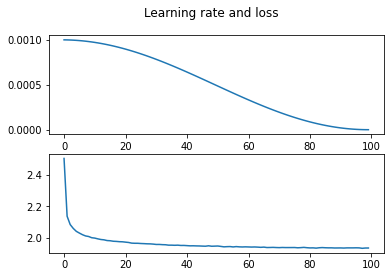

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [9]:
model.eval()
test_regular_sampler()

How are you? I'm just an actor?"<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [10]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: s{reply}\n\n")

Prompt: How are you?
Reply: spark2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park


Prompt: What do you think of Lorem?
Reply: spark2<msg>Ad "I think he's a good guy."<p><msg>c "I'm not sure."<p><msg>c "I'm not sure."<d><scn>park2<msg>Ad "I'm not sure."<p><msg>c "I'm not sure."<p><msg>c "I


Prompt: Oh my god, Adine. What is this?
Reply: sfacin2<msg>An "I'm not sure, but I'm not sure I can do anything to help."<p><msg>c "I'm not sure I can do anything to help."<d><scn>facin2<msg>An "I'm not sure I can do anything to help."<p><msg>c "I'm not sure I can do anything to help


Prompt: What will we do here?
Reply: snp1n<msg>m "I looked at the results of the test. I could see that the results were mixed results."<d><scn>np1n<msg>m "I was about to leave, but I didn't want to go."<d><scn>np1n<msg>m "I was about to leave, but I didn't want to go."<d><scn>np1




# Sampling test

This is gonna be interesting!

In [11]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "I'm good, thanks."<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ry "He's an incredibly kind person. He is an honest person, and he will not take the same pressure to prove what he is capable of."<p><msg>c "He's an honest person, and he will not take the same pressure to prove what he is capable of."<d><scn>park2<msg>Ry

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: facin2<msg>An "Adine, I was wondering what you would do if I didn't take a few steps. Is this normal? I mean, I don't even know what to call it. I just feel like a big boy."<p><msg>c "That's a weird thing to do, but I guess that's something I'm not going to ask for. Maybe I'll ask

[Test 1] -> Prompt: What will we do here?
Reply: np2x<msg>m "A little something, I think."<d><scn>np2x<msg>m "She looked at me and said, "I'm just curious. How did you come here?"<p><msg>c "I'm just curious."<d><scn>np2x<msg>m "I watched the procee

# RP test
Testing out the injected roleplay actions

In [13]:
test_rps = [
    "Visit Adine"
]
for rp in test_rps:
    print(model_manager.say("", rp, top_k = 50, top_p = 0.7))

black<msg>An "I guess I'll let you go."<|endoftext|>
